# 0. Preparación del entorno

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [11]:
os.environ['RUTA_SIMULACIONES'] = '/content/drive/MyDrive/UCLM/MUII/TFM/code/src/data/simulaciones/'
os.environ['RUTA_DATASETS'] = '/content/drive/MyDrive/UCLM/MUII/TFM/code/src/data/datasets/'
os.environ['DATASET_CONSUMOS'] = 'consumos_casas_1-99'
os.environ['MAX_HOUSE_LOAD'] = '99'

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Arquitectura

## 1.1. Utils

In [4]:
def obtener_ruta_archivo(nombre: str, parte: int = 0):
  ruta_archivo = f"{os.environ.get('RUTA_SIMULACIONES')}{nombre}"
  if parte != 0:
    ruta_archivo += f"_part{parte}"
  ruta_archivo += ".xlsx"
  return ruta_archivo

assert obtener_ruta_archivo("House1", 1) == os.environ.get('RUTA_SIMULACIONES') + 'House1_part1.xlsx'
assert obtener_ruta_archivo("House1", 0) == os.environ.get('RUTA_SIMULACIONES') + 'House1.xlsx'

In [5]:
def obtener_n_dias(ruta_archivo: str):
  xls = pd.ExcelFile(ruta_archivo)
  return len([d for d in xls.sheet_names if d.startswith('Day')]);

assert obtener_n_dias(os.environ.get('RUTA_SIMULACIONES') + 'House1.xlsx') == 10

In [6]:
def leer_consumo_excel(dia: int, casa: str, parte: int = 0):
  serie = pd.read_excel(obtener_ruta_archivo(casa, parte), sheet_name=f'Day{dia}', header=None).iloc[0]
  data = [int(x) for x in serie if not isinstance(x, str)]
  return data

## 1.2. Modelos

In [7]:
class Consumo:
  def __init__(self, dia: int, casa: str, parte: int = 0, serie: list[int] = []):
    self.dia: int = dia
    self.casa: str = casa
    self.parte: int = parte
    self._serie: list[int] = serie

  def get_serie(self) -> list[int]:
    return [c for c in self._serie]

  def leer_serie(self):
    self._serie = leer_consumo_excel(self.dia, self.casa, self.parte)

In [8]:
class GrupoConsumos:
  def __init__(self):
    self._consumos: list[Consumo] = []
    self._n_consumos = 0

  def get_consumos(self) -> list[Consumo]:
    return [c for c in self._consumos]

  def get_consumo(self, dia: int, casa: str, parte: int = 0) -> Consumo:
    return next((c for c in self._consumos if c.dia == dia and c.casa == casa and c.parte == parte), None)

  def add_consumo(self, consumo: Consumo):
    self._consumos.append(consumo)
    self._n_consumos += 1

  def guardar_como_excel(self, nombre_archivo: str = 'consumos_casas_1-100'):
    data = []
    for consumo in self._consumos:
      data.append({
        'dia': consumo.dia,
        'casa': consumo.casa,
        'parte': consumo.parte,
        'serie': consumo.get_serie()
      })
    df = pd.DataFrame(data)
    df.to_excel(f"{os.environ.get('RUTA_DATASETS')}{nombre_archivo}.xlsx", index=False)

  def carga_desde_excel(self, nombre_archivo: str):
    df = pd.read_excel(f"{os.environ.get('RUTA_DATASETS')}{nombre_archivo}.xlsx")
    self._consumos = []
    self._n_consumos = 0
    for _, row in df.iterrows():
      consumo = Consumo(row['dia'], row['casa'], row['parte'], eval(row['serie']))
      self.add_consumo(consumo)


# X. Main

### Generación o lectura del dataset con todas las series temporales de consumo

In [12]:
consumos_simulados = GrupoConsumos()
dataset_consumos = os.environ.get('DATASET_CONSUMOS')

if dataset_consumos == '':
  for i in range(1, int(os.environ.get('MAX_HOUSE_LOAD'))+1):
    casa = f"House{i}"
    for d in range(1, obtener_n_dias(obtener_ruta_archivo(casa)) + 1):
      consumo = Consumo(d, casa)
      consumo.leer_serie()
      consumos_simulados.add_consumo(consumo)
  consumos_simulados.guardar_como_excel(f"consumos_casas_1-{os.environ.get('MAX_HOUSE_LOAD')}")
else:
  consumos_simulados.carga_desde_excel(dataset_consumos)

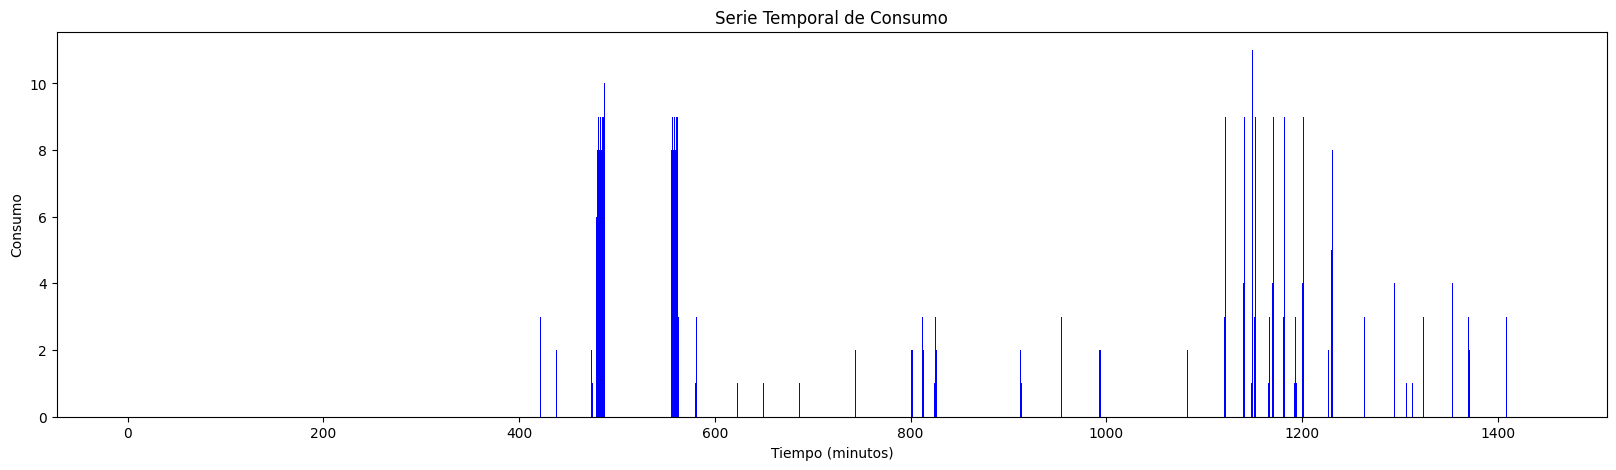

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Ejemplo de datos de serie temporal con 1440 posiciones
serie_temporal = next(consumo.get_serie() for consumo in consumos_simulados.get_consumos() if max(consumo.get_serie()) > 6 and sum(consumo.get_serie()) > 30)  # Datos aleatorios para la demostración

# Crear la gráfica de barras
plt.figure(figsize=(20, 5))  # Tamaño de la figura
plt.bar(range(1440), serie_temporal, color='blue')
plt.xlabel('Tiempo (minutos)')
plt.ylabel('Consumo')
plt.title('Serie Temporal de Consumo')
plt.show()
